In [1]:
# !pip install catboost optuna

In [2]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [20]:
import os
import re

from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, pairwise_distances
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

# import optuna

from scipy.spatial.distance import pdist, squareform

import pickle

from scipy.sparse import csr_matrix, coo_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb


Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

#### General

In [4]:
datapath = './data/' # local
# datapath = r'/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/' # colab
# datapath = r'/kaggle/input/drivendata-earthquake/' # kaggle

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [5]:
def preprocess(df_features):
    # Convert numeric features to float
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

In [6]:
# Feature groups
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
# non_geo_features_w_label = categorical_features + numerical_features + ['damage_grade']
# for geo_feat in geo_features:
#     non_geo_features_w_label.remove(geo_feat)

### AutoEncode Geography (Pytorch)

#### Impute damage_grade of test features

In [44]:
def impute_damage_grade(df_train_X: pd.DataFrame,df_val_X: pd.DataFrame,
                        df_test_X: pd.DataFrame,df_pred_X: pd.DataFrame,
                        df_train_y: pd.DataFrame, df_val_y: Optional[pd.DataFrame]=None,
                        df_test_y: Optional[pd.DataFrame]=None) -> pd.DataFrame:
    '''
    Impute damage grade based on location (i.e. the three geo features). This function
    
    The original dataset
    should first be split into train, val and test sets. The imputation will be done using all
    features from all datasets, but only labels from the train dataset to prevent date leakage.
    df_train_X: Post splitting X dataframe for training
    df_val_X: Post splitting X dataframe for validation set
    df_test_X: Post splt
    '''
    # Preprocess to convert numerical features to float
    df_train_X = preprocess(df_train_X.copy())
    df_val_X = preprocess(df_val_X.copy())
    df_test_X = preprocess(df_test_X.copy())
    df_pred_X = preprocess(df_pred_X.copy())

    df_all = pd.concat([df_train_X,df_train_y],axis=1)
    
    if df_val_y is not None:
        df_val_X = pd.concat([df_val_X,df_val_y],axis=1)
    if df_test_y is not None:
        df_test_X = pd.concat([df_test_X,df_test_y],axis=1)
        
    df_all = pd.concat([df_all,df_val_X,df_test_X,df_pred_X],axis=0)

    df_all['geo_combined3'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']) + '_' + str(row['geo_level_3_id']), axis=1)
    df_all['geo_combined2'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']), axis=1)

    # Fillna for damage_grade with means for geo level 3
    damage_means3 = df_all.groupby('geo_combined3')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means3[row['geo_combined3']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Fillna for damage_grade with means for lowest geo level 2
    damage_means2 = df_all.groupby('geo_combined2')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means2[row['geo_combined2']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Fillna for damage_grade with means for lowest geo level 2
    damage_means1 = df_all.groupby('geo_level_1_id')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means1[row['geo_level_1_id']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Drop unwanted columns
    df_all.drop(columns=['geo_combined2','geo_combined3'],inplace=True)
    df_all = pd.get_dummies(df_all,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)

    # Get feature names
    non_geo_features_OHE = [col for col in df_all.columns if not (col in geo_features)]

    return df_all, non_geo_features_OHE

In [26]:
# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y)

#### Geo-features + other categorical features
To iterate over:
1. architecture and weights
2. latent size
3. Number of epochs

In [27]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    def __init__(self, geo1_size, geo2_size, geo3_size, inter_size, latent_size):
        super(CategoricalAutoencoder, self).__init__()
        self.geo1_size = geo1_size
        self.geo2_size = geo2_size
        self.geo3_size = geo3_size

        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, geo1_size)
        self.embed2 = nn.Embedding(1418, geo2_size)
        self.embed3 = nn.Embedding(11861, geo3_size)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(geo1_size + geo2_size + geo3_size + 58, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, geo1_size + geo2_size + geo3_size + 58)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(geo1_size, 31)
        self.output2 = nn.Linear(geo2_size, 1418)
        self.output3 = nn.Linear(geo3_size, 11861)
        
    def forward(self, x1, x2, x3, feats):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3, feats], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [self.geo1_size, self.geo2_size, self.geo3_size, 58], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out, feats_recon

def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute the loss
            loss = criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch)
            
            loss_feat = nn.MSELoss()(feats_recon, feats_batch)

            total_loss = loss + loss_feat

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3

In [ ]:
geo_n_lat_n = [(16,32,64,128,64),(16,32,64,128,32),(16,32,64,128,16),(16,32,64,128,8),(16,32,64,128,4)]
geo_n_lat_n += [(8,16,32,64,32),(8,16,32,64,16),(8,16,32,64,8),(8,16,32,64,4)]
geo_n_lat_n += [(4,8,16,64,32),(4,8,16,64,16),(4,8,16,64,8),(4,8,16,64,4)]
epo_n = [1,2,4,8,10,12,16,20,25,30,40]

for combo in geo_n_lat_n:
    for epochs in epo_n:
        geo1_size = combo[0]
        geo2_size = combo[1]
        geo3_size = combo[2]
        inter_size = combo[3]
        latent_size = combo[4]

        pickle_name = f'latent_geo_geo1_{geo1_size}_geo2_{geo2_size}_geo3_{geo3_size}_inter_{inter_size}_lat_{latent_size}_epo_{epochs}.pkl'

        print(f'\n\n\n~~~~~~~~~~~~~~~~~Now running {pickle_name[:-4]}~~~~~~~~~~~~~~~~~')

        latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

        with open(pickle_name,'wb') as f:
            pickle.dump(latent_geo,f)

## CatBoost
Quick check with vanilla approach

In [7]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_test_features = preprocess(df_test_features_raw)

X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
 
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=X_val, label=y_val, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

In [17]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU',devices='0',metric_period=100)

# Grid search training
grid = {'iterations': [600,800],
        'learning_rate': [0.1,0.2],
        'depth': [8],
        'l2_leaf_reg': [5]}
model.grid_search(grid, train_dataset,verbose=False)

with open('cb_1.pkl','wb') as f:
    pickle.dump(model,f)

0:	learn: 2.0999503	test: 2.1026331	best: 2.1026331 (0)	total: 36.4ms	remaining: 21.8s
100:	learn: 0.4604643	test: 0.4565330	best: 0.4565330 (100)	total: 3.04s	remaining: 15s
200:	learn: 0.4570157	test: 0.4539142	best: 0.4539142 (200)	total: 5.98s	remaining: 11.9s
300:	learn: 0.4551188	test: 0.4528420	best: 0.4528420 (300)	total: 8.89s	remaining: 8.83s
400:	learn: 0.4534276	test: 0.4518584	best: 0.4518584 (400)	total: 11.8s	remaining: 5.85s
500:	learn: 0.4520410	test: 0.4511871	best: 0.4511871 (500)	total: 14.7s	remaining: 2.9s
599:	learn: 0.4509619	test: 0.4506409	best: 0.4506409 (599)	total: 17.6s	remaining: 0us
bestTest = 0.4506408541
bestIteration = 599
0:	learn: 1.8815759	test: 1.8839833	best: 1.8839833 (0)	total: 32.4ms	remaining: 19.4s
100:	learn: 0.4567280	test: 0.4537866	best: 0.4537866 (100)	total: 3.02s	remaining: 14.9s
200:	learn: 0.4543522	test: 0.4524706	best: 0.4524706 (200)	total: 5.84s	remaining: 11.6s
300:	learn: 0.4524312	test: 0.4515912	best: 0.4515912 (300)	total: 

In [22]:
# # Load model
# with open('cb_1.pkl','rb') as f:
#     model = pickle.load(f)
model.get_params()

{'loss_function': 'RMSE',
 'metric_period': 100,
 'task_type': 'GPU',
 'devices': '0',
 'depth': 8,
 'learning_rate': 0.2,
 'l2_leaf_reg': 5,
 'iterations': 800}

In [23]:
# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

Testing performance
RMSE: 0.44
R2: 0.48


0.7452354761965669

In [28]:
# Single model and evaluation
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

0:	learn: 0.5696507	total: 14.1ms	remaining: 28.2s
500:	learn: 0.4266956	total: 5.68s	remaining: 17s
1000:	learn: 0.4061295	total: 11.4s	remaining: 11.4s
1500:	learn: 0.3882719	total: 17.1s	remaining: 5.69s
1999:	learn: 0.3722416	total: 22.9s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.48


0.7470773323782968

## CatBoost geo encoded

### General Flow

In [26]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# # Save geo-encoding
# with open('latent_geo_1.pkl','wb') as f:
#     pickle.dump(latent_geo, f)

# # Load geo-encoding
# with open('latent_geo_1.pkl','rb') as f:
#     latent_geo = pickle.load(f)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_dataset)

# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

### Parametric Study - Select Best Encoding

In [7]:
# Prep dataframe for storing validation scores
encoding_path = './kaggle_output_1/'
encoders = []
for file in os.listdir(encoding_path):
    if file.endswith(".pkl"):
        encoders.append(file)

# Define the patterns to extract numbers after specific substrings
patterns = {
    'geo1': r'geo1_(\d+)',
    'geo2': r'geo2_(\d+)',
    'geo3': r'geo3_(\d+)',
    'inter': r'inter_(\d+)',
    'lat': r'lat_(\d+)',
    'epo': r'epo_(\d+)'
}

archis = []
for encoder in encoders:
    # Extract numbers using regex
    extracted_numbers = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, encoder)
        if match:
            extracted_numbers[key] = int(match.group(1))
    archis.append(extracted_numbers)

archis = pd.DataFrame(archis)
archis['val_rmse'] = None
archis['val_r2'] = None
archis['val_f1'] = None
archis['iterations'] = None

In [8]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

num_encoders = len(encoders)

iterationss = [2000]
for iterations in iterationss:
    for j, encoder in enumerate(encoders):
        print(f'\n\n Running encoder: {encoder}, {j} of {num_encoders}')
        # Load encoder
        with open(encoding_path+encoder,'rb') as f:
            latent_geo = pickle.load(f)

        # Apply encoder
        df_train_X_temp = df_train_X.merge(latent_geo,on=geo_features,how='left')
        df_train_X_temp.drop(columns=geo_features, inplace=True)
        df_val_X_temp = df_val_X.merge(latent_geo,on=geo_features,how='left')
        df_val_X_temp.drop(columns=geo_features, inplace=True)

        # Get categorical feature indices and names
        categorical_features_indices = []
        for i,dtype in enumerate(df_train_X_temp.dtypes):
            if dtype in ['int64','int32','object','category']:
                categorical_features_indices.append(i)

        # Creating pooled datasets for catboost
        train_dataset = cb.Pool(data=df_train_X_temp, label=df_train_y, cat_features=categorical_features_indices)
        val_dataset = cb.Pool(data=df_val_X_temp, label=df_val_y, cat_features=categorical_features_indices)

        # Instantiate catboost regressor model and fit
        model = cb.CatBoostRegressor(loss_function='RMSE',
                                    task_type='GPU',devices='0',
                                    metric_period=500,
                                    iterations=iterations, learning_rate=0.2, depth=8,l2_leaf_reg=5)
        model.fit(train_dataset)

        # Evaluation
        pred = model.predict(df_val_X_temp)
        rmse = (np.sqrt(mean_squared_error(df_val_y, pred)))
        r2 = r2_score(df_val_y, pred)
        pred_int = np.round(np.clip(pred,1,3))
        f1 = f1_score(df_val_y,pred_int,average='micro')

        print(f'RMSE: {rmse}, R2-score: {r2}, F1-score: {f1}, iterations = {iterations}')

        archis.loc[j,'rmse'] = rmse
        archis.loc[j,'r2'] = r2
        archis.loc[j,'f1'] = f1
        archis.loc[j,'iterations'] = iterations



 Running encoder: latent_geo_geo1_8_geo2_16_geo3_32_inter_64_lat_64_epo_10.pkl, 0 of 165
0:	learn: 0.5843077	total: 15.9ms	remaining: 31.7s
500:	learn: 0.4138695	total: 6.26s	remaining: 18.7s
1000:	learn: 0.3904681	total: 12.8s	remaining: 12.8s
1500:	learn: 0.3719462	total: 19.4s	remaining: 6.46s
1999:	learn: 0.3563713	total: 26s	remaining: 0us
RMSE: 0.44442203062732943, R2-score: 0.47233073905325973, F1-score: 0.743160682577422, iterations = 2000


 Running encoder: latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_32_epo_1.pkl, 1 of 165
0:	learn: 0.5868244	total: 12.3ms	remaining: 24.6s
500:	learn: 0.4168597	total: 6.07s	remaining: 18.2s
1000:	learn: 0.3920407	total: 12.4s	remaining: 12.3s
1500:	learn: 0.3729770	total: 18.6s	remaining: 6.19s
1999:	learn: 0.3564956	total: 25s	remaining: 0us
RMSE: 0.44473263359874626, R2-score: 0.47159291373522016, F1-score: 0.742107322358323, iterations = 2000


 Running encoder: latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_32_epo_8.pkl, 2 of 165

In [9]:
archis.to_csv('param_study_2000.csv',index=None)

### playground

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df_temp500 = pd.read_csv('./kaggle_output_1/param_study_500.csv')
df_temp1000 = pd.read_csv('./kaggle_output_1/param_study_1000.csv')
df_temp1500 = pd.read_csv('./kaggle_output_1/param_study_1500.csv')
df_temp2000 = pd.read_csv('./kaggle_output_1/param_study_2000.csv')

df_temp500['iterations'] = 500
df_temp1000['iterations'] = 1000
df_temp1500['iterations'] = 1500
df_temp2000['iterations'] = 2000

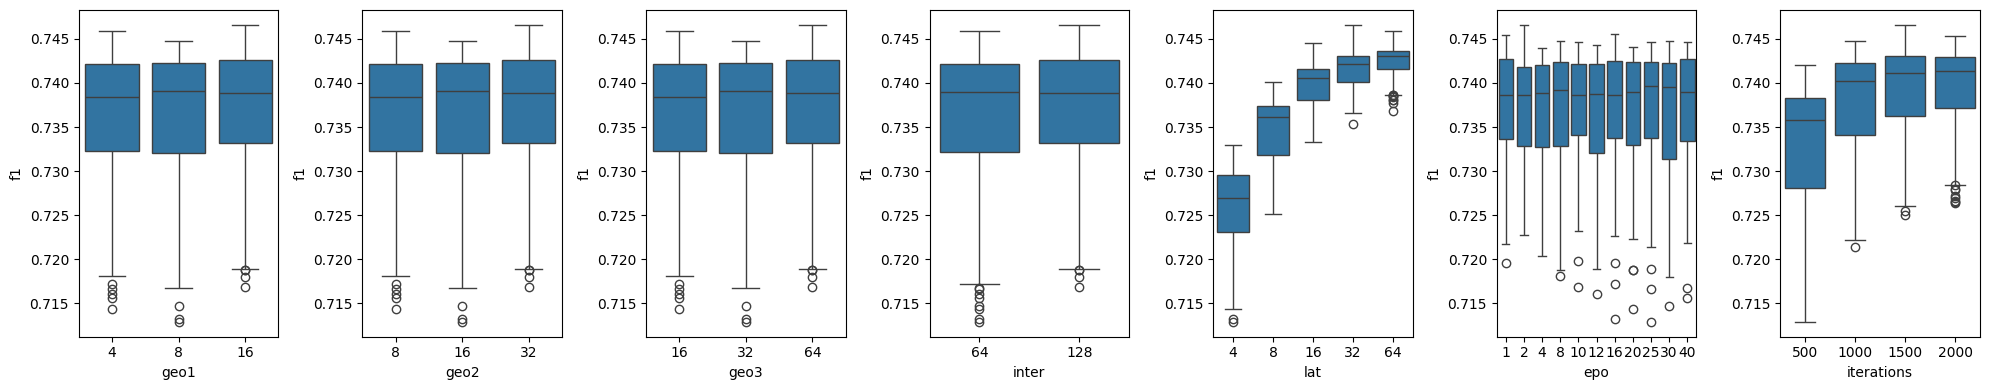

In [13]:
vars = ['geo1', 'geo2', 'geo3', 'inter', 'lat', 'epo','iterations']

fig,axs = plt.subplots(1,7,figsize=(20,4))

df_temp = pd.concat([df_temp500,df_temp1000, df_temp1500,df_temp2000],axis=0)

for i,var in enumerate(vars):
    sns.boxplot(df_temp,x=var,y='f1',ax=axs[i])
    # axs[i].set_title(var)
fig.tight_layout()

In [19]:
encoding_path = './kaggle_output_1/'
encoder = 'latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_64_epo_10.pkl'
iterations = 2000


with open(encoding_path+encoder,'rb') as f:
    latent_geo = pickle.load(f)

# Apply encoder
df_train_X_temp = df_train_X.merge(latent_geo,on=geo_features,how='left')
# df_train_X_temp.drop(columns=geo_features, inplace=True)
df_val_X_temp = df_val_X.merge(latent_geo,on=geo_features,how='left')
# df_val_X_temp.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X_temp.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Creating pooled datasets for catboost
train_dataset = cb.Pool(data=df_train_X_temp, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X_temp, label=df_val_y, cat_features=categorical_features_indices)

# Instantiate catboost regressor model and fit
model = cb.CatBoostRegressor(loss_function='RMSE',
                            task_type='GPU',devices='0',
                            metric_period=500,
                            iterations=iterations, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

# Evaluation
pred = model.predict(df_val_X_temp)
rmse = (np.sqrt(mean_squared_error(df_val_y, pred)))
r2 = r2_score(df_val_y, pred)
pred_int = np.round(np.clip(pred,1,3))
f1 = f1_score(df_val_y,pred_int,average='micro')

print(f'RMSE: {rmse}, R2-score: {r2}, F1-score: {f1}, iterations = {iterations}')

0:	learn: 0.5698391	total: 12.9ms	remaining: 25.8s
500:	learn: 0.4149541	total: 7.11s	remaining: 21.3s
1000:	learn: 0.3904455	total: 14.4s	remaining: 14.4s
1500:	learn: 0.3701735	total: 21.8s	remaining: 7.24s
1999:	learn: 0.3526150	total: 29.1s	remaining: 0us
RMSE: 0.4429841599214712, R2-score: 0.47573962857447116, F1-score: 0.7452674030156198, iterations = 2000


In [28]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X,
                                                   df_train_y,df_val_y=df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# # Save geo-encoding
# with open('latent_geo_1.pkl','wb') as f:
#     pickle.dump(latent_geo, f)

# # Load geo-encoding
# with open('latent_geo_1.pkl','rb') as f:
#     latent_geo = pickle.load(f)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.24it/s]


Epoch [1/10], Loss: 6.729512283175262


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.70it/s]


Epoch [2/10], Loss: 0.4600596437628473


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.17it/s]


Epoch [3/10], Loss: 0.21556302925519677


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.06it/s]


Epoch [4/10], Loss: 0.14945167441343524


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.77it/s]


Epoch [5/10], Loss: 0.1237711031836854


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.56it/s]


Epoch [6/10], Loss: 0.09953249051833638


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.60it/s]


Epoch [7/10], Loss: 0.0789221092772777


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.39it/s]


Epoch [8/10], Loss: 0.07518974689747733


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.72it/s]


Epoch [9/10], Loss: 0.07538896804616824


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.87it/s]


Epoch [10/10], Loss: 0.05806747793851095


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1323.33it/s]


In [32]:
# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_dataset)

# Evaluation
pred = model.predict(df_test_X)
rmse = (np.sqrt(mean_squared_error(df_test_y, pred)))
r2 = r2_score(df_test_y, pred)
pred_int = np.round(np.clip(pred,1,3))
f1 = f1_score(df_test_y,pred_int,average='micro')

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'F1-score: {f1:.2f}')

0:	learn: 0.5692218	total: 13ms	remaining: 26.1s
500:	learn: 0.4173449	total: 7.79s	remaining: 23.3s
1000:	learn: 0.3954131	total: 15.6s	remaining: 15.6s
1500:	learn: 0.3776221	total: 23.6s	remaining: 7.83s
1999:	learn: 0.3620162	total: 31.5s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.49
F1-score: 0.75


<BarContainer object of 102 artists>

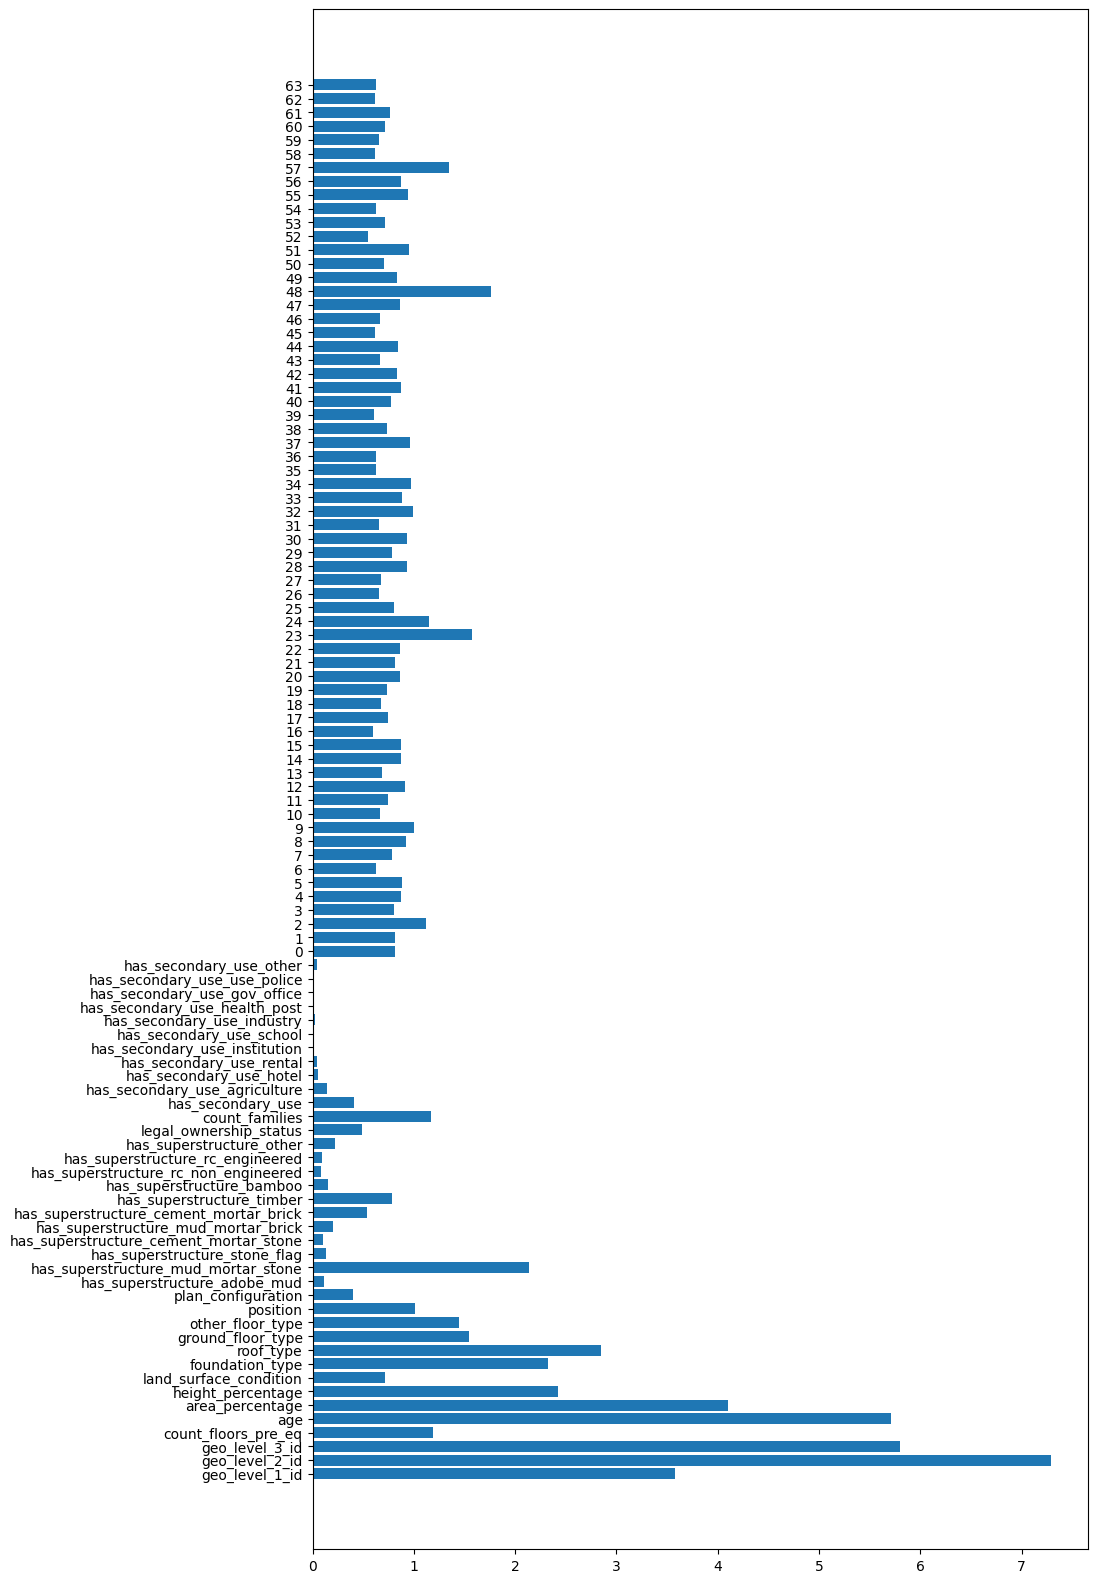

In [39]:
cols = [str(col) for col in df_train_X.columns]

imps = model.feature_importances_
fig,ax = plt.subplots(1,1,figsize=(10,20))
ax.barh(cols,imps)


## Final Model Work

### Sub1 - Quick model with first run geo encoding

In [27]:
# Final model and predict
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

0:	learn: 0.5830191	total: 13.4ms	remaining: 26.9s
500:	learn: 0.4176732	total: 6.03s	remaining: 18.1s
1000:	learn: 0.3976800	total: 12.1s	remaining: 12.1s
1500:	learn: 0.3831543	total: 18.2s	remaining: 6.04s
1999:	learn: 0.3712832	total: 24.2s	remaining: 0us


In [30]:
# Predict
# Load geo-encoding
with open('latent_geo_1.pkl','rb') as f:
    latent_geo = pickle.load(f)

df_final_pred = df_test_features.merge(latent_geo,on=geo_features,how='left')
df_final_pred.drop(columns=geo_features, inplace=True)
pred = model.predict(df_final_pred)
pred_int = np.round(np.clip(pred,1,3)).astype('int')

In [39]:
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub1.csv',index=False)

### Sub 2 - Baseline with just simple CatBoost without any geo encoding or fancy preprocessing

In [42]:
datapath = './data/' # local

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_pred_features = preprocess(df_pred_features_raw)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_features.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_features, label=df_train_labels_raw, cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

0:	learn: 0.5688387	total: 23ms	remaining: 45.9s
500:	learn: 0.4286066	total: 6.39s	remaining: 19.1s
1000:	learn: 0.4128214	total: 12.8s	remaining: 12.7s
1500:	learn: 0.3994321	total: 19.2s	remaining: 6.37s
1999:	learn: 0.3873596	total: 25.5s	remaining: 0us


In [43]:
pred = model.predict(df_pred_features)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub2.csv',index=False)

### Sub 3 - geo-encoding with 'optimized' autoencoder network, and not dropping original geo features

In [53]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X,
                                                   df_train_y,
                                                   df_val_y = df_val_y, df_test_y = df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub3.csv',index=False)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.80it/s]


Epoch [1/10], Loss: 6.872932761293097


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.04it/s]


Epoch [2/10], Loss: 0.47606034987278295


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.37it/s]


Epoch [3/10], Loss: 0.20224445410873823


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.41it/s]


Epoch [4/10], Loss: 0.14613145800370486


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.43it/s]


Epoch [5/10], Loss: 0.1012515675479516


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.90it/s]


Epoch [6/10], Loss: 0.1035112255869779


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.16it/s]


Epoch [7/10], Loss: 0.08537420844477471


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.67it/s]


Epoch [8/10], Loss: 0.05823486810532948


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 533.40it/s]


Epoch [9/10], Loss: 0.07236936649066548


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.94it/s]


Epoch [10/10], Loss: 0.04893300779870559


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1365.79it/s]


0:	learn: 0.5693521	total: 15.6ms	remaining: 31.1s
500:	learn: 0.4180906	total: 8.83s	remaining: 26.4s
1000:	learn: 0.3989183	total: 17.9s	remaining: 17.8s
1500:	learn: 0.3831546	total: 26.9s	remaining: 8.94s
1999:	learn: 0.3691349	total: 36s	remaining: 0us
